In [1]:
import numpy as np
import sys
sys.path.append("../../../")
from SWIDP.process_1d_shallow import augment_workflow
from SWIDP.dispersion import generate_mixed_samples,calculate_dispersion,transform_vp_to_vs,transform_vs_to_vel_model
from p_tqdm import p_map

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

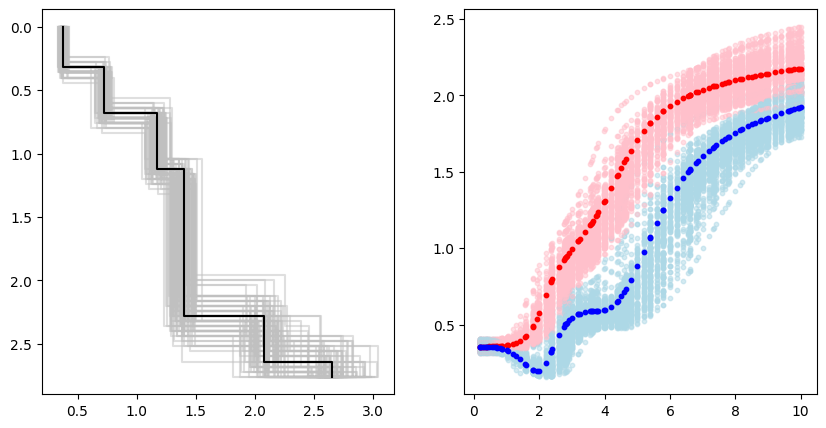

In [2]:
# step1: get 1d velocity model (vp model or vs)
depth_vp = np.loadtxt("./vp_demo.txt")
depth = depth_vp[:,0]
vp = depth_vp[:,1]

# step2: generate velocity model (depth, vp, vs, rho)
vs = transform_vp_to_vs(vp)

# step3: vs model augmentation
augment_nums = 100
vs_perturbation = 0.05 # relative ratio
thickness_perturbation = 0.1 # relative ratio
vel_threshold = 0.05 # km/s
thickness_threshold = 0.01 # km
min_layers_num = 3 
smooth_vel = False
smoothnodes = 10
vs_augmented = augment_workflow(vs,depth,
                              perturb_num = augment_nums,
                              vs_perturbation=vs_perturbation,
                              thickness_perturbation=thickness_perturbation,
                              vel_threshold=vel_threshold,
                              thickness_threshold=thickness_threshold,
                              min_layers_num=min_layers_num,
                              smooth_vel=smooth_vel,
                              smooth_nodes=smoothnodes)

# step4: generate velocity model (depth, vp, vs, rho)
vel_model_augmented = p_map(transform_vs_to_vel_model,list(vs_augmented),[depth]*len(vs_augmented))

# step5: generate dispersion curves [t,phase velocity, group velocity]
t = generate_mixed_samples(num_samples=100,start=0.2,end=10,uniform_num=50,log_num=20,random_num=30)
disp = p_map(calculate_dispersion,vel_model_augmented,[t]*len(vel_model_augmented))


import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(121)
for i in range(len(vel_model_augmented)):
    plt.step(vel_model_augmented[i][:,2],depth,c='silver',alpha=0.5)
plt.step(vel_model_augmented[0][:,2],depth,c='k')
plt.gca().invert_yaxis()

plt.subplot(122)
for i in range(len(disp)):
    plt.scatter(disp[i][:,0],disp[i][:,1],s=10,c='pink',alpha=0.5)
    plt.scatter(disp[i][:,0],disp[i][:,2],s=10,c='lightblue',alpha=0.5)
plt.scatter(disp[0][:,0],disp[0][:,1],s=10,c='r')
plt.scatter(disp[0][:,0],disp[0][:,2],s=10,c='b')
plt.show()